In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_set/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.shape

(568454, 10)

<Axes: xlabel='Score'>

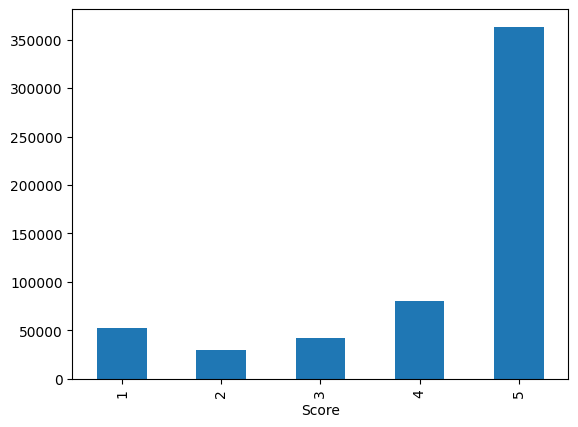

In [ ]:
df.Score.value_counts().sort_index().plot(kind='bar')

In [ ]:
sample=df['Text'].values[0]
sample

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))
negations = {
    "not", "no", "nor", "n't",
    "don't", "doesn't", "didn't", "won't", "wouldn't", "couldn't",
    "shouldn't", "wasn't", "weren't", "haven't", "hasn't", "hadn't",
    "isn't", "aren't", "mustn't", "mightn't", "needn't", "shan't"
}
stop_words = stop_words - negations

print(stop_words)

{"we're", 'as', "you'd", 'into', 'd', 'how', "i've", 'it', 't', 'having', 'themselves', 'are', "he's", "they're", 'isn', 'has', 'why', 'after', 'before', 'because', 'yourselves', 'himself', 'at', 'couldn', 'o', 'own', "she's", 'its', 'below', 'y', 'herself', 'mightn', "we've", 'so', 'm', 'up', 'am', 'he', 'out', "she'd", "she'll", 'theirs', 'then', 'but', 'wouldn', 'be', 'myself', "i'll", 'ourselves', 'very', 'than', "we'll", 's', 'ain', 'her', "i'm", 'won', 'only', 'can', 'for', 'should', 'some', 'your', 'doing', 'more', 'our', 'don', 'these', 'did', "that'll", 'when', 'here', "we'd", 'have', 'yours', 'between', 'any', 'does', 'weren', 'is', 'other', 'above', 'too', 'with', 'who', 'him', 'being', 've', 'shan', 'down', 'against', 'further', "you're", 'while', 'just', 'you', 'over', 'them', 'shouldn', 'now', 'whom', "you've", "should've", "i'd", 'my', 'this', 'those', 'were', 'both', 'by', 'and', "they've", 'the', 'most', 'i', 'of', 'needn', 'we', 'which', 'doesn', 'was', 'his', "it'll"

In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'@\w+', '', text)           # Remove mentions
    text = re.sub(r'http\S+', '', text)        # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)    # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()   # Normalize whitespace

    # Tokenization using regex
    tokens = re.findall(r'\b\w+\b', text)

    # Stopword removal
    tokens = [word for word in tokens if word not in stop_words]

    return ' '.join(tokens)

In [ ]:
df['Text'] = df['Text'].apply(preprocess_text)

In [ ]:
text = "Jumped into the lake! It's not amazing @user http://link.com"
print(preprocess_text(text))


jumped lake not amazing


In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,bought several vitality canned dog food produc...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled jumbo salted peanutsth...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",confection around centuries light pillowy citr...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,looking secret ingredient robitussin believe f...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffy great price wide assortment yummy ...


In [ ]:
df['Label']=df['Score'].apply(lambda x: 1 if x > 3 else 0)

In [ ]:
df=df[['Text','Label']]
df.Label.value_counts()

,count
Label,
1,443777
0,124677


In [ ]:
df.duplicated().sum()

np.int64(175397)

In [ ]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [ ]:
df.isna().sum()

,0
Text,0
Label,0


In [ ]:
df.Label.value_counts()

,count
Label,
1,306378
0,86679


In [ ]:
import pandas as pd
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.Label==1]
df_minority = df[df.Label==0]

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority)+500,     # to match minority class
                                 random_state=42) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
df_downsampled.Label.value_counts()



,count
Label,
1,87179
0,86679


In [ ]:
# Now use df_downsampled for your vectorization and modeling

vectorizer = TfidfVectorizer(max_features=15000, ngram_range=(1,2))
X_tf_idf = vectorizer.fit_transform(df_downsampled['Text'])

In [ ]:
y=df_downsampled['Label']

In [ ]:
# Split data into training and testing sets
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf_idf, y, test_size=0.25,stratify=y, random_state=42)


In [ ]:
X_train_tf.shape, X_test_tf.shape

((130393, 15000), (43465, 15000))

In [ ]:
y_train_tf.value_counts(), y_test_tf.value_counts()

(Label
 1    65384
 0    65009
 Name: count, dtype: int64,
 Label
 1    21795
 0    21670
 Name: count, dtype: int64)

In [ ]:
#evaluate function
def Evaluation_func(model_name, X_train, y_train, X_test, y_test):
    # Train Accuracy
    y_pred_train = model_name.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    report_train = classification_report(y_train, y_pred_train)

    #Train Acc
    print("Train Data Accuracy:\n")
    print(f"Accuracy Score: {accuracy_train * 100:.2f}%")
    print(f"F1 Score: {f1_train * 100:.2f}%")
    print("Classification Report:\n", report_train)
    print('-'*50,'\n')


    #Test Accuracy
    y_pred = model_name.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report=classification_report(y_test, y_pred)

    #Test Acc
    print("Test Data Accuracy:\n")
    print(f"Accuracy Score: {accuracy * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    print("Classification Report:\n", report)
    print('-'*50,'\n')



    plt.figure(figsize=(10, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title('Test Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
log_model_tfidf=LogisticRegression(random_state=42)
log_model_tfidf.fit(X_train_tf, y_train_tf)

LogisticRegression(random_state=42)

Train Data Accuracy:

Accuracy Score: 89.31%
F1 Score: 89.32%
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89     65009
           1       0.89      0.89      0.89     65384

    accuracy                           0.89    130393
   macro avg       0.89      0.89      0.89    130393
weighted avg       0.89      0.89      0.89    130393

-------------------------------------------------- 

Test Data Accuracy:

Accuracy Score: 87.54%
F1 Score: 87.52%
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.88     21670
           1       0.88      0.87      0.88     21795

    accuracy                           0.88     43465
   macro avg       0.88      0.88      0.88     43465
weighted avg       0.88      0.88      0.88     43465

-------------------------------------------------- 



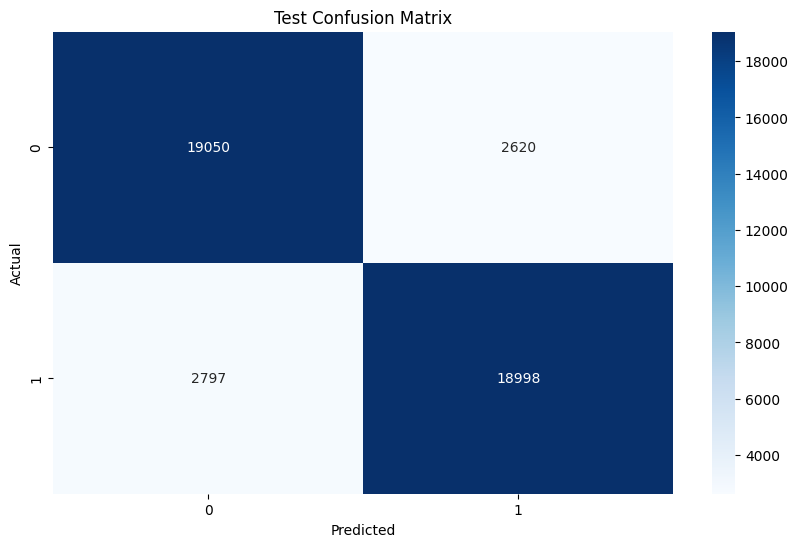

In [ ]:
Evaluation_func(log_model_tfidf, X_train_tf, y_train_tf, X_test_tf, y_test_tf)


# MultinomialNB

In [ ]:
MNB = MultinomialNB()
MNB.fit(X_train_tf, y_train_tf)

MultinomialNB()

Train Data Accuracy:

Accuracy Score: 86.49%
F1 Score: 86.49%
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86     65009
           1       0.87      0.86      0.86     65384

    accuracy                           0.86    130393
   macro avg       0.86      0.86      0.86    130393
weighted avg       0.86      0.86      0.86    130393

-------------------------------------------------- 

Test Data Accuracy:

Accuracy Score: 85.78%
F1 Score: 85.77%
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86     21670
           1       0.86      0.85      0.86     21795

    accuracy                           0.86     43465
   macro avg       0.86      0.86      0.86     43465
weighted avg       0.86      0.86      0.86     43465

-------------------------------------------------- 



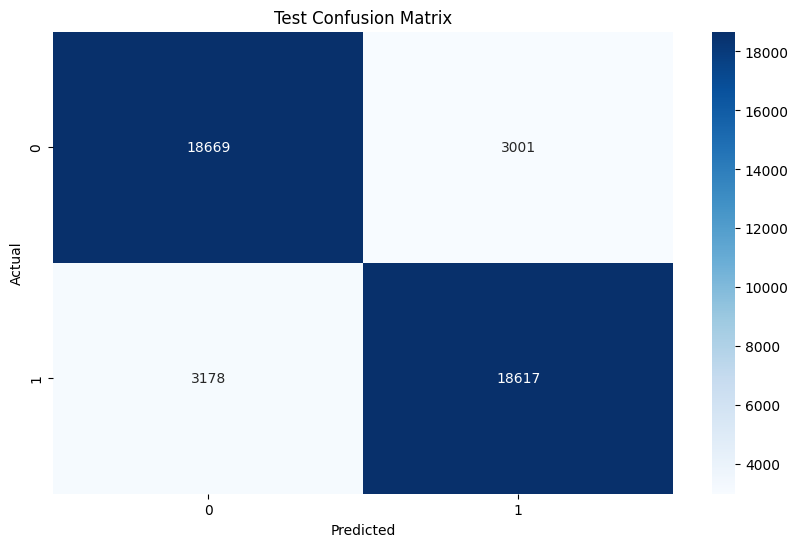

In [ ]:
Evaluation_func(MNB, X_train_tf, y_train_tf, X_test_tf, y_test_tf)

In [ ]:
# import pickle

# # Save the trained Logistic Regression model
# filename = 'log_model_tfidf.pkl'
# pickle.dump(log_model_tfidf, open(filename, 'wb'))

# # # Save the trained Naive Bayes model
# # filename = 'MultinomialNB_model.pkl'
# # pickle.dump(MNB, open(filename, 'wb'))

# # Save the TF-IDF vectorizer
# filename = 'tfidf_vectorizer.pkl'
# pickle.dump(vectorizer, open(filename, 'wb'))


In [ ]:
import pandas as pd
from sklearn.utils import resample


max_features = 15000  # Adjust as needed
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df_downsampled['Text'].values)

X = tokenizer.texts_to_sequences(df_downsampled['Text'].values)
X = pad_sequences(X)


In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [ ]:
Y = pd.get_dummies(df_downsampled['Label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(130393, 1825) (130393, 2)
(43465, 1825) (43465, 2)


In [ ]:
X_train=X_train[:40000]
Y_train=Y_train[:40000]

In [ ]:
batch_size = 64
model.fit(X_train, Y_train, epochs = 1, batch_size=batch_size, verbose = 2)

In [ ]:
loss,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("Loss: %.2f" % (loss))
print("acc: %.2f" % (acc))


In [ ]:
# Save the trained LSTM model

model.save('lstm_model.h5')

# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
